# **IDL Project Assignment: Task 1 - Optimizers**

###Importing required Libraries

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import keras

In [ ]:
tf.__version__

'2.3.0'

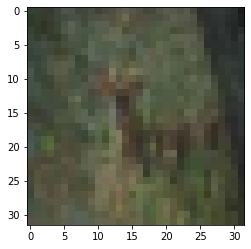

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
plt.imshow(train_images[10], cmap=plt.cm.binary)

In [ ]:
train_images.shape, train_labels.shape

((50000, 32, 32, 3), (50000, 1))

In [ ]:
batch_size = 2048
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_data = train_data.shuffle(10000, seed=1, reshuffle_each_iteration=True)
train_data = train_data.batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_data = test_data.shuffle(10000, seed=1, reshuffle_each_iteration=True)
test_data = test_data.batch(batch_size)

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) =fashion_mnist.load_data() 
# print(train_labels[0])
# plt.imshow(train_images[0], cmap= 'Greys_r')
data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1,28,28,1]).astype(np.float32)/255,train_labels.astype(np.int32)))
data_fmnist = data.shuffle(buffer_size =120000).batch(2048).repeat(4)

test_data_fmnist = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1,28,28,1]).astype(np.float32)/255, test_labels.astype(np.int32))).batch(128)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
data_fmnist

<RepeatDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def model_config(act_fn, config):
  ## Architecture 1
  layers_config1 = [
          tf.keras.layers.Conv2D(32,3,padding='same',activation=act_fn,input_shape=(32,32,3)),
          tf.keras.layers.Conv2D(32,3,padding='same',activation=act_fn),
          tf.keras.layers.MaxPool2D((2,2)),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Conv2D(64,3,padding='same',activation=act_fn),
          tf.keras.layers.Conv2D(64,3,padding='same',activation=act_fn),
          tf.keras.layers.MaxPool2D((2,2)),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Conv2D(128,3,padding='same',activation=act_fn),
          tf.keras.layers.Conv2D(128,3,padding='same',activation=act_fn),
          tf.keras.layers.MaxPool2D((2,2)),
          tf.keras.layers.Dropout(0.4),

          tf.keras.layers.Conv2D(256,3,padding='same',activation=act_fn),
          tf.keras.layers.MaxPool2D((2,2)),
          tf.keras.layers.Dropout(0.25),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128,activation=act_fn),
          #tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Dense(256,activation=act_fn),
          tf.keras.layers.Dense(512,activation=act_fn),
          tf.keras.layers.Dense(10)]
  
  ## Architecture 2
  layers_config2 = [
          # tf.keras.layers.Conv2D(8,3,padding='same',activation=act_fn,input_shape=(32,32,3)),
          # tf.keras.layers.Conv2D(8,3,padding='same',activation=act_fn),
          # tf.keras.layers.MaxPool2D((2,2)),
          # tf.keras.layers.Dropout(0.1),

          # tf.keras.layers.Conv2D(16,3,padding='same',activation=act_fn),
          # tf.keras.layers.Conv2D(16,3,padding='same',activation=act_fn),
          # tf.keras.layers.MaxPool2D((2,2)),
          # tf.keras.layers.Dropout(0.2),
          
          
          keras.layers.Conv2D(filters= 16,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu',input_shape=(28,28,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Conv2D(filters= 32,kernel_size=[5,5],kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),use_bias = True,bias_initializer='zeros',padding = 'same',activation = 'relu'),
                          keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10,use_bias= True,bias_initializer='zeros' )
                          ]
  

    ## Define the model
  if config == 'layers_config1':
    model = tf.keras.Sequential(layers_config1)
       
  else:
    model = tf.keras.Sequential(layers_config2)
   

  return model

In [ ]:
## Train the model
def train(opt_type, n_epochs, model, lr):
    if opt_type == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif opt_type == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=lr)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_list = []
    step_list = []
    acc_list = []
    steps = 0
    for epoch in range(n_epochs):
       
        for img_batch, lbl_batch in data_fmnist:
            # print(img_batch.shape, lbl_batch.shape)
            steps = steps+1
            with tf.GradientTape(persistent=True) as tape:
                logits = model(img_batch, training=True)
                loss_value = loss_fn(lbl_batch, logits)
            grads = tape.gradient(loss_value, model.trainable_weights)

            opt.apply_gradients(zip(grads, model.trainable_weights))
            acc = train_acc_metric(lbl_batch, logits)
            
        if not epoch % 2:
          print('Epoch no %d' % (epoch,))
          print("Loss: {} Accuracy: {}".format(loss_value, train_acc_metric.result()))
          train_acc_metric.reset_states()
        loss_list.append(loss_value)
        step_list.append(steps)
        acc_list.append(acc)
    return loss_list, step_list, acc_list

###For Architecture 1 and CIFAR 10:

In [ ]:
# Layer Architecture 1 : Adam : Relu

n_epoch, lr = 100, 0.001
opt_type, act_fn, config = 'Adam', 'relu', 'layers_config1'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)



arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
AR1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
AR1.columns = ['Steps', 'Accuracy', 'Loss']


test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))
print("Test acc: {}".format(test_acc_metric.result()))

Epoch no 0
Loss: 2.3005337715148926 Accuracy: 0.10412000119686127
Epoch no 2
Loss: 2.019705057144165 Accuracy: 0.1693200021982193
Epoch no 4
Loss: 1.7608832120895386 Accuracy: 0.2888199985027313
Epoch no 6
Loss: 1.6121619939804077 Accuracy: 0.3804300129413605
Epoch no 8
Loss: 1.3765660524368286 Accuracy: 0.4414199888706207
Epoch no 10
Loss: 1.335778832435608 Accuracy: 0.49035000801086426
Epoch no 12
Loss: 1.2968050241470337 Accuracy: 0.527180016040802
Epoch no 14
Loss: 1.1562373638153076 Accuracy: 0.5648099780082703
Epoch no 16
Loss: 1.1090513467788696 Accuracy: 0.5919399857521057
Epoch no 18
Loss: 1.0315881967544556 Accuracy: 0.6202200055122375
Epoch no 20
Loss: 1.015511155128479 Accuracy: 0.6479300260543823
Epoch no 22
Loss: 0.8581581115722656 Accuracy: 0.6672599911689758
Epoch no 24
Loss: 0.7952304482460022 Accuracy: 0.684469997882843
Epoch no 26
Loss: 0.826123058795929 Accuracy: 0.7009400129318237
Epoch no 28
Loss: 0.7811809778213501 Accuracy: 0.7149099707603455
Epoch no 30
Loss: 0

In [ ]:
# Layer Architecture 1 : Adam : Tanh
n_epoch, lr = 100, 0.001
opt_type, act_fn, config = 'Adam', 'tanh', 'layers_config1'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)


arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
# arc1_loss, arc1_acc, arc1_steps = loss_arr, step_arr, acc_arr
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
AT1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
AT1.columns = ['Steps', 'Accuracy', 'Loss']


test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))
print("Test acc: {}".format(test_acc_metric.result()))

Epoch no 0
Loss: 1.865912675857544 Accuracy: 0.23217999935150146
Epoch no 2
Loss: 1.5085824728012085 Accuracy: 0.40022000670433044
Epoch no 4
Loss: 1.2471692562103271 Accuracy: 0.5212200284004211
Epoch no 6
Loss: 1.1026370525360107 Accuracy: 0.576479971408844
Epoch no 8
Loss: 1.0787091255187988 Accuracy: 0.6243000030517578
Epoch no 10
Loss: 0.9418576955795288 Accuracy: 0.654229998588562
Epoch no 12
Loss: 0.8427178859710693 Accuracy: 0.6773099899291992
Epoch no 14
Loss: 0.7938975691795349 Accuracy: 0.6942099928855896
Epoch no 16
Loss: 0.7536179423332214 Accuracy: 0.7172200083732605
Epoch no 18
Loss: 0.7323787808418274 Accuracy: 0.7307100296020508
Epoch no 20
Loss: 0.6619481444358826 Accuracy: 0.7422999739646912
Epoch no 22
Loss: 0.6591154932975769 Accuracy: 0.7522600293159485
Epoch no 24
Loss: 0.7083302736282349 Accuracy: 0.7655100226402283
Epoch no 26
Loss: 0.6150623559951782 Accuracy: 0.7730100154876709
Epoch no 28
Loss: 0.6203017234802246 Accuracy: 0.7780699729919434
Epoch no 30
Loss

In [ ]:
# Layer Architecture 1 : SGD : Relu
n_epoch, lr = 100, 0.01
opt_type, act_fn, config = 'SGD', 'relu', 'layers_config1'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)

arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
# arc1_loss, arc1_acc, arc1_steps = loss_arr, step_arr, acc_arr
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
SR1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
SR1.columns = ['Steps', 'Accuracy', 'Loss']


test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))
print("Test acc: {}".format(test_acc_metric.result()))

Epoch no 0
Loss: 2.2968544960021973 Accuracy: 0.10552000254392624
Epoch no 2
Loss: 2.2867915630340576 Accuracy: 0.10417000204324722
Epoch no 4
Loss: 2.270207166671753 Accuracy: 0.10461000353097916
Epoch no 6
Loss: 2.2806081771850586 Accuracy: 0.11118999868631363
Epoch no 8
Loss: 2.2691357135772705 Accuracy: 0.1245800033211708
Epoch no 10
Loss: 2.266116142272949 Accuracy: 0.136680006980896
Epoch no 12
Loss: 2.2654316425323486 Accuracy: 0.1453000009059906
Epoch no 14
Loss: 2.252164125442505 Accuracy: 0.15072999894618988
Epoch no 16
Loss: 2.2450368404388428 Accuracy: 0.16158999502658844
Epoch no 18
Loss: 2.2296605110168457 Accuracy: 0.16690999269485474
Epoch no 20
Loss: 2.2467215061187744 Accuracy: 0.17563000321388245
Epoch no 22
Loss: 2.2028284072875977 Accuracy: 0.1830900013446808
Epoch no 24
Loss: 2.2142226696014404 Accuracy: 0.18957999348640442
Epoch no 26
Loss: 2.1943790912628174 Accuracy: 0.19352999329566956
Epoch no 28
Loss: 2.1800618171691895 Accuracy: 0.20309999585151672
Epoch no

In [ ]:
# Layer Architecture 1 : SGD : Tanh
n_epoch, lr = 100, 0.01
opt_type, act_fn, config = 'SGD', 'tanh', 'layers_config1'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)


arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
#arc1_loss, arc1_acc, arc1_steps = loss_arr, step_arr, acc_arr
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
ST1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
ST1.columns = ['Steps', 'Accuracy', 'Loss']


test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))
print("Test acc: {}".format(test_acc_metric.result()))

Epoch no 0
Loss: 2.2849464416503906 Accuracy: 0.11727999895811081
Epoch no 2
Loss: 2.1691412925720215 Accuracy: 0.16907000541687012
Epoch no 4
Loss: 2.0942978858947754 Accuracy: 0.1902499943971634
Epoch no 6
Loss: 2.057551383972168 Accuracy: 0.22458000481128693
Epoch no 8
Loss: 2.189580202102661 Accuracy: 0.24597999453544617
Epoch no 10
Loss: 1.8944132328033447 Accuracy: 0.2708500027656555
Epoch no 12
Loss: 1.8991304636001587 Accuracy: 0.2840900123119354
Epoch no 14
Loss: 1.9210002422332764 Accuracy: 0.3140999972820282
Epoch no 16
Loss: 1.7731413841247559 Accuracy: 0.3289799988269806
Epoch no 18
Loss: 1.7788294553756714 Accuracy: 0.33570000529289246
Epoch no 20
Loss: 1.7749483585357666 Accuracy: 0.34804999828338623
Epoch no 22
Loss: 1.7076574563980103 Accuracy: 0.35346001386642456
Epoch no 24
Loss: 1.6586170196533203 Accuracy: 0.36520999670028687
Epoch no 26
Loss: 1.6597228050231934 Accuracy: 0.37213000655174255
Epoch no 28
Loss: 1.7467951774597168 Accuracy: 0.3723500072956085
Epoch no

In [ ]:
def plot_performance(df1, df2, df3, df4):
  fig = plt.figure(figsize = (12,6))
  (ax1, ax2) = fig.subplots(1,2)
  steps = df1['Steps']
  loss1 = df1['Loss']
  accuracy1 = df1['Accuracy']
  loss2 = df2['Loss']
  accuracy2 = df2['Accuracy']
  loss3 = df3['Loss']
  accuracy3 = df3['Accuracy']
  loss4 = df4['Loss']
  accuracy4 = df4['Accuracy']

  ax1.plot(steps,loss1, label = 'Loss(Adam and Relu)')
  ax1.plot(steps,loss2, label = 'Loss(Adam and Tanh)')
  ax1.plot(steps,loss3, label = 'Loss(SGD and Relu)')
  ax1.plot(steps,loss4, label = 'Loss(SGD and Tanh)')

  ax2.plot(steps,accuracy1, label = 'Accuracy(Adam and Relu)')
  ax2.plot(steps,accuracy2, label = 'Accuracy(Adam and Tanh)')
  ax2.plot(steps,accuracy3, label = 'Accuracy(SGD and Relu)')
  ax2.plot(steps,accuracy4, label = 'Accuracy(SGD and Tanh)')

  ax1.set_title('Loss v/s Steps')
  ax2.set_title(' Accuracy v/s Steps')
  ax1.set_xlabel("Steps", fontsize = 14)
  ax1.set_ylabel("Loss", fontsize = 14)
  ax2.set_xlabel("Steps", fontsize = 14)
  ax2.set_ylabel("Accuracy", fontsize = 14)
  ax1.legend(loc="upper right")
  ax2.legend(loc="lower right")
  plt.tight_layout()

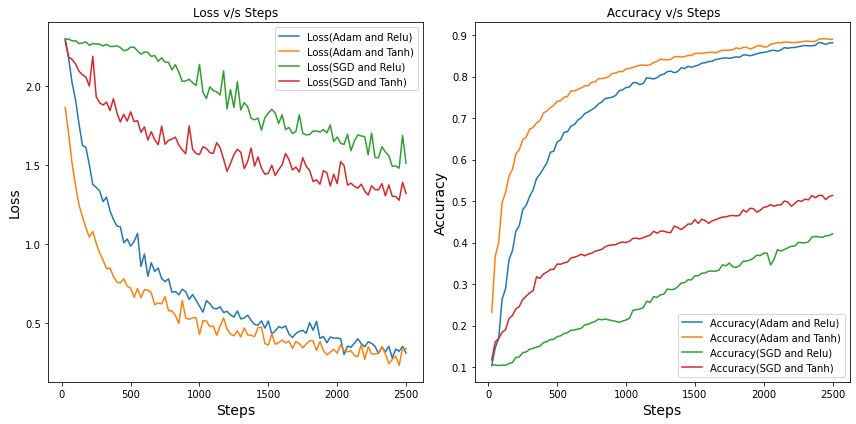

In [ ]:
plot_performance(AR1, AT1, SR1, ST1)

###For Architecture 2 and FMNIST:

In [ ]:
del loss_list
del step_list
del acc_list

In [ ]:
# Layer Architecture 2 : Adam : Relu

n_epoch, lr = 100, 0.001
opt_type, act_fn, config = 'Adam', 'relu', 'layers_config2'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)

arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
AR1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
AR1.columns = ['Steps', 'Accuracy', 'Loss']


# test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# for img_batch, lbl_batch in test_data:
#     test_acc_metric(lbl_batch, model(img_batch))
# print("Test acc: {}".format(test_acc_metric.result()))

In [ ]:
# Layer Architecture 2 : Adam : Tanh
n_epoch, lr = 100, 0.001
opt_type, act_fn, config = 'Adam', 'tanh', 'layers_config2'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)

arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
AT1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
AT1.columns = ['Steps', 'Accuracy', 'Loss']


# test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# for img_batch, lbl_batch in test_data:
#     test_acc_metric(lbl_batch, model(img_batch))
# print("Test acc: {}".format(test_acc_metric.result()))

Epoch no 0
Loss: 0.5638625621795654 Accuracy: 0.7173666954040527
Epoch no 2
Loss: 0.3965514600276947 Accuracy: 0.8508541584014893
Epoch no 4
Loss: 0.356298565864563 Accuracy: 0.8760687708854675
Epoch no 6
Loss: 0.25907275080680847 Accuracy: 0.887806236743927
Epoch no 8
Loss: 0.3508796989917755 Accuracy: 0.8960291743278503
Epoch no 10
Loss: 0.23862963914871216 Accuracy: 0.9016854166984558
Epoch no 12
Loss: 0.19861170649528503 Accuracy: 0.9071520566940308
Epoch no 14
Loss: 0.2681539058685303 Accuracy: 0.9114229083061218
Epoch no 16
Loss: 0.2864246368408203 Accuracy: 0.9151041507720947
Epoch no 18
Loss: 0.2026335597038269 Accuracy: 0.9175729155540466
Epoch no 20
Loss: 0.23425960540771484 Accuracy: 0.9210333228111267
Epoch no 22
Loss: 0.19234499335289001 Accuracy: 0.9243375062942505
Epoch no 24
Loss: 0.17005480825901031 Accuracy: 0.9266791939735413
Epoch no 26
Loss: 0.2023296058177948 Accuracy: 0.929520845413208
Epoch no 28
Loss: 0.16864842176437378 Accuracy: 0.9314083456993103
Epoch no 30

In [ ]:
# Layer Architecture 2 : SGD : Relu

n_epoch, lr = 100, 0.01
opt_type, act_fn, config = 'SGD', 'relu', 'layers_config2'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)

arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
SR1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
SR1.columns = ['Steps', 'Accuracy', 'Loss']


# test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# for img_batch, lbl_batch in test_data:
#     test_acc_metric(lbl_batch, model(img_batch))
# print("Test acc: {}".format(test_acc_metric.result()))

Epoch no 0
Loss: 2.2459278106689453 Accuracy: 0.21770000457763672
Epoch no 2
Loss: 0.9676896929740906 Accuracy: 0.5631520748138428
Epoch no 4
Loss: 0.7844576835632324 Accuracy: 0.7078458070755005
Epoch no 6
Loss: 0.6730596423149109 Accuracy: 0.7472249865531921
Epoch no 8
Loss: 0.6158382296562195 Accuracy: 0.7671645879745483
Epoch no 10
Loss: 0.5967323780059814 Accuracy: 0.7821187376976013
Epoch no 12
Loss: 0.6269295811653137 Accuracy: 0.7926229238510132
Epoch no 14
Loss: 0.5758821368217468 Accuracy: 0.8024895787239075
Epoch no 16
Loss: 0.5322136878967285 Accuracy: 0.8114854097366333
Epoch no 18
Loss: 0.45635008811950684 Accuracy: 0.8182353973388672
Epoch no 20
Loss: 0.4663276672363281 Accuracy: 0.8252479434013367
Epoch no 22
Loss: 0.4845643937587738 Accuracy: 0.830943763256073
Epoch no 24
Loss: 0.4503120481967926 Accuracy: 0.835881233215332
Epoch no 26
Loss: 0.40795180201530457 Accuracy: 0.8403124809265137
Epoch no 28
Loss: 0.44611242413520813 Accuracy: 0.8443312644958496
Epoch no 30
L

In [ ]:
# Layer Architecture 2 : SGD : Tanh
n_epoch, lr = 100, 0.01
opt_type, act_fn, config = 'SGD', 'tanh', 'layers_config2'
model = model_config(act_fn, config)
loss_list, step_list, acc_list = train(opt_type, n_epoch, model, lr)

arc1_loss, arc1_acc, arc1_steps = loss_list, acc_list, step_list
arc1_acc, arc1_loss, arc1_steps = [elem.numpy() for elem in arc1_acc], [elem.numpy() for elem in arc1_loss], arc1_steps
ST1 = pd.DataFrame([arc1_steps, arc1_acc, arc1_loss]).T
ST1.columns = ['Steps', 'Accuracy', 'Loss']


# test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# for img_batch, lbl_batch in test_data:
#     test_acc_metric(lbl_batch, model(img_batch))
# print("Test acc: {}".format(test_acc_metric.result()))

Epoch no 0
Loss: 2.185635805130005 Accuracy: 0.1590166687965393
Epoch no 2
Loss: 0.8437984585762024 Accuracy: 0.5951770544052124
Epoch no 4
Loss: 0.7315406799316406 Accuracy: 0.7059375047683716
Epoch no 6
Loss: 0.5872864127159119 Accuracy: 0.7449416518211365
Epoch no 8
Loss: 0.6642231941223145 Accuracy: 0.765749990940094
Epoch no 10
Loss: 0.5917501449584961 Accuracy: 0.7802583575248718
Epoch no 12
Loss: 0.5412809252738953 Accuracy: 0.7921249866485596
Epoch no 14
Loss: 0.46717724204063416 Accuracy: 0.8023583292961121
Epoch no 16
Loss: 0.5286884903907776 Accuracy: 0.811870813369751
Epoch no 18
Loss: 0.5228907465934753 Accuracy: 0.8210562467575073
Epoch no 20
Loss: 0.45460274815559387 Accuracy: 0.8290145993232727
Epoch no 22
Loss: 0.4314950704574585 Accuracy: 0.8348291516304016
Epoch no 24
Loss: 0.4664632976055145 Accuracy: 0.8396478891372681
Epoch no 26
Loss: 0.45407891273498535 Accuracy: 0.8439145684242249
Epoch no 28
Loss: 0.46243512630462646 Accuracy: 0.8483083248138428
Epoch no 30
Lo

In [ ]:
def plot_performance(df1, df2, df3, df4):
  fig = plt.figure(figsize = (12,6))
  (ax1, ax2) = fig.subplots(1,2)
  steps = df1['Steps']
  loss1 = df1['Loss']
  accuracy1 = df1['Accuracy']
  loss2 = df2['Loss']
  accuracy2 = df2['Accuracy']
  loss3 = df3['Loss']
  accuracy3 = df3['Accuracy']
  loss4 = df4['Loss']
  accuracy4 = df4['Accuracy']

  ax1.plot(steps,loss1, label = 'Loss(Adam and Relu)')
  ax1.plot(steps,loss2, label = 'Loss(Adam and Tanh)')
  ax1.plot(steps,loss3, label = 'Loss(SGD and Relu)')
  ax1.plot(steps,loss4, label = 'Loss(SGD and Tanh)')

  ax2.plot(steps,accuracy1, label = 'Accuracy(Adam and Relu)')
  ax2.plot(steps,accuracy2, label = 'Accuracy(Adam and Tanh)')
  ax2.plot(steps,accuracy3, label = 'Accuracy(SGD and Relu)')
  ax2.plot(steps,accuracy4, label = 'Accuracy(SGD and Tanh)')

  ax1.set_title('Loss v/s Steps')
  ax2.set_title(' Accuracy v/s Steps')
  ax1.set_xlabel("Steps", fontsize = 14)
  ax1.set_ylabel("Loss", fontsize = 14)
  ax2.set_xlabel("Steps", fontsize = 14)
  ax2.set_ylabel("Accuracy", fontsize = 14)
  ax1.legend(loc="upper right")
  ax2.legend(loc="lower right")
  plt.tight_layout()

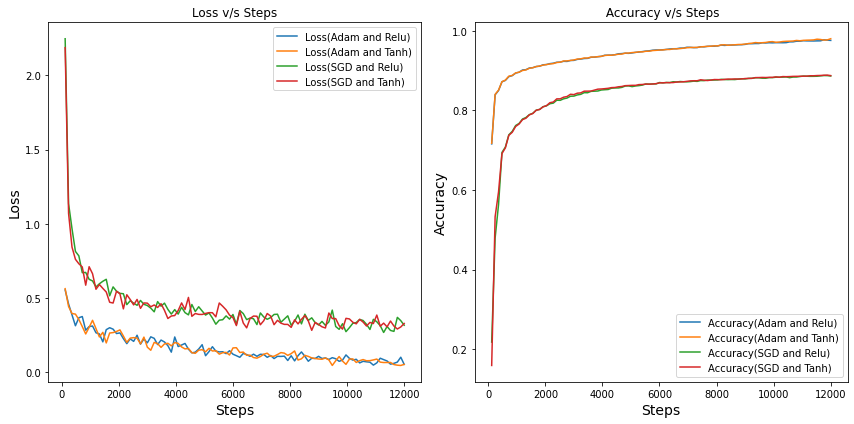

In [ ]:
plot_performance(AR1, AT1, SR1, ST1)

Observations:

For Architecture 1 and CIFAR 10 dataset:

The train accuracy given by using Adam optimizer is way better than SGD for the same number of epochs. Also, using tanh activation function, model seems to perform better as compared to the Relu activation function.

For architecture 2 and FMNIST dataset:

The train accuracy given by using Adam optimizer is better than SGD for the same number of epochs. Adam and Relu perform almost equally the same according to the graph plotted.




